In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
%cd /content/drive/MyDrive/프로젝트 폴더/code/Opinion_analysis/Training_data

/content/drive/.shortcut-targets-by-id/1fmVXXO9WkxfQqimV76GhZhDAdNd3hhtJ/프로젝트 폴더/code/Opinion_analysis/Training_data


In [ ]:
# # 형태소 분석기 패키지 다운로드
# pip install konlpy

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 리뷰데이터 분석

## 학습습 데이터

* 총 500,000개 리뷰로 구성된 데이터로 영화 리뷰, 쇼핑 리뷰, 게임 리뷰뷰에 대한 텍스트
* 해당 리뷰가 긍정인 경우 1, 부정인 경우 0을 표시한 레이블로 구성하도록 전처리함

In [5]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f238ff2ceb0>)

In [6]:
# 각 데이터 읽기, column name을 설정
data_movie_train = pd.read_table('ratings_train.txt')
data_movie_test = pd.read_table('ratings_test.txt')
data_shopping = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
data_steam = pd.read_table('steam.txt', names=['label', 'reviews'])

# 데이터의 레이블을 추가해준다 평점 4,5인 리뷰에는 레이블 1, 평점 1,2,인 리뷰에는 0을 부여
data_shopping['label'] = np.select([data_shopping.ratings > 3], [1], default=0)

# 불필요한  column 제거
data_movie_test = data_movie_test.drop('id', axis=1)
data_movie_train = data_movie_train.drop('id', axis=1)
data_shopping = data_shopping.drop('ratings', axis=1)
data_movie_train = data_movie_train.rename(columns={'document':'reviews'})
data_movie_test = data_movie_test.rename(columns={'document':'reviews'})

In [7]:
# 같은 형식으로 만들고 하나의 dataframe으로 만듬
df_list = [data_movie_test, data_shopping, data_movie_train,data_steam]
train_data = pd.concat(df_list, ignore_index=False)
train_data.shape

(500000, 2)

In [8]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 500000


In [9]:
train_data[:5]

,reviews,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
# 데이터 정제 
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['reviews'].nunique(), train_data['label'].nunique()

(493987, 2)

In [11]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 493988


In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  247106
1      1  246882


In [13]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-14-9b76e0dba9da>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,reviews,label
0,굳 ㅋ,1
1,,0
2,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [15]:
#  train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인
train_data['reviews'] = train_data['reviews'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-15-9357552eb4db>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


reviews    1025
label         0
dtype: int64


In [16]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

492962


In [18]:
from collections import Counter

In [19]:
# 토큰화 (https://soohee410.github.io/compare_tagger) - 불용어사전 : 형태소 분석 후 나온 조사, 접속어, 지시대명사 등 문장의 의미와 크게 연관 없는 단어 제외
stopwords = ['가', '걍', '게', '게임', '겜', '고', '과', '네', '는', '다', '도', '되', '들', '듯', '를', '만', '면', '명작', '영화', '에', '와', '으로', '은', '을', '음', '의', '이', '인', '임', '자', '잘', '좀', '지', '하', '하다', '한']   # 불용어(조사,접속사 불필요한 단어 추가)

f = open("불용어사전.txt", 'r')
while True:
    line = f.readline()
    if not line: break
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()
print(stopwords)

['가', '걍', '게', '게임', '겜', '고', '과', '네', '는', '다', '도', '되', '들', '듯', '를', '만', '면', '명작', '영화', '에', '와', '으로', '은', '을', '음', '의', '이', '인', '임', '자', '잘', '좀', '지', '하', '하다', '한', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '곳', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면'

In [20]:
okt = Okt()
word_list=[]
for i,j in okt.pos(okt.normalize('상당히 맛있는 집이네요')):
  if j=='Noun':
    word_list.append(i)
  if j=='Adjective':
    word_list.append(i)

# okt.pos('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')
# okt.nouns('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')
# okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', norm=True, stem = True)
# okt.nouns('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

count_items = Counter(word_list)

# 가장 많은 item 찾기
max_item = count_items.most_common(n=3)
print(max_item)

[('상당히', 1), ('맛있는', 1)]


In [21]:
X_train = []
for sentence in tqdm(train_data['reviews']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 492962/492962 [21:28<00:00, 382.73it/s]

[['굳다', 'ㅋ'], ['뭐', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '돈', '주다', '보기', '에는']]


In [22]:
# 정수 인코딩
tokenizer = Tokenizer()
# 단어 집합(vocaburary) 생성
tokenizer.fit_on_texts(X_train)

In [23]:
print(tokenizer.word_index)

{'보다': 1, '좋다': 2, '너무': 3, '없다': 4, '이다': 5, '되다': 6, '안': 7, '않다': 8, '요': 9, '배송': 10, '자다': 11, '아니다': 12, '생각': 13, '그냥': 14, '정말': 15, '먹다': 16, '못': 17, '재밌다': 18, '적': 19, '진짜': 20, '오다': 21, '재다': 22, '사다': 23, '더': 24, '구매': 25, '하고': 26, '쓰다': 27, '나오다': 28, '거': 29, '받다': 30, '만들다': 31, '들다': 32, '개': 33, '안되다': 34, '사용': 35, '내': 36, '많이': 37, '그렇다': 38, '모르다': 39, '점': 40, '가격': 41, '빠르다': 42, '사람': 43, '별로': 44, 'ㅠㅠ': 45, '제품': 46, '가다': 47, '많다': 48, '중': 49, '스토리': 50, '수': 51, '맛': 52, '주다': 53, '최고': 54, '보고': 55, '서': 56, '정도': 57, '괜찮다': 58, '인데': 59, '주문': 60, '재미있다': 61, '크다': 62, '맞다': 63, '알다': 64, '재미': 65, '나다': 66, '말': 67, '넘다': 68, '추천': 69, '뭐': 70, '버리다': 71, '좋아하다': 72, 'ㅋㅋ': 73, '이렇다': 74, '싶다': 75, '처음': 76, '느낌': 77, '다시': 78, '아깝다': 79, '평점': 80, '연기': 81, '해보다': 82, '써다': 83, '돈': 84, '걸': 85, '해주다': 86, '되어다': 87, '아쉽다': 88, 'ㅠ': 89, '만족하다': 90, '사이즈': 91, '두': 92, '부분': 93, '분': 94, '라': 95, '이라': 96, '완전': 97, '이쁘다': 98, 'ㅎㅎ': 99, '맛있다': 100, '포

In [24]:
# 도수가 낮은 단어들은 자연어 처리에서 배제
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작은 단어를 카운트한다.
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100,'%')
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100,'%')

단어 집합(vocabulary)의 크기 : 85520
등장 빈도가 1번 이하인 희귀 단어의 수: 40724
단어 집합에서 희귀 단어의 비율: 47.619270346117865 %
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8124407736581182 %


In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 44797


In [26]:
# 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [27]:
print(X_train[:3]) 

[[568, 135], [70, 80, 324, 8, 40, 211, 674, 24, 994, 12], [123, 8, 97, 790, 84, 53, 264, 147]]


In [28]:
y_train = np.array(train_data['label'])

In [29]:
# 빈 샘플(empty samples) 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [30]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

492062
492062


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.104064122000887


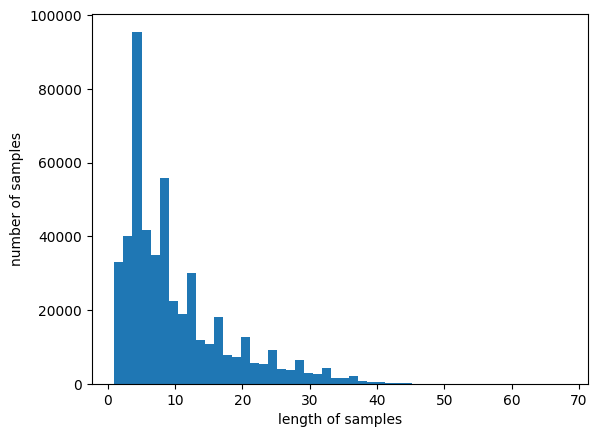

In [31]:
# 패딩 : 서로 다른 길이의 샘플들의 길이를 동일하게
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [33]:
# 문장 최대길이 제한
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.99634192439164


In [34]:
# 모든 샘플의 길이를 50으로 맞춤
X_train = pad_sequences(X_train, maxlen=max_len)

## 4. BiLSTM 리뷰 감성 분류

In [35]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
1538/1538 [==============================] - ETA: 0s - loss: 0.3745 - acc: 0.8356
Epoch 1: val_acc improved from -inf to 0.71651, saving model to best_model.h5
1538/1538 [==============================] - 81s 45ms/step - loss: 0.3745 - acc: 0.8356 - val_loss: 0.6041 - val_acc: 0.7165
Epoch 2/15
1538/1538 [==============================] - ETA: 0s - loss: 0.3193 - acc: 0.8677
Epoch 2: val_acc improved from 0.71651 to 0.71763, saving model to best_model.h5
1538/1538 [==============================] - 28s 18ms/step - loss: 0.3193 - acc: 0.8677 - val_loss: 0.6178 - val_acc: 0.7176
Epoch 3/15
1538/1538 [==============================] - ETA: 0s - loss: 0.2950 - acc: 0.8791
Epoch 3: val_acc improved from 0.71763 to 0.71801, saving model to best_model.h5
1538/1538 [==============================] - 27s 18ms/step - loss: 0.2950 - acc: 0.8791 - val_loss: 0.5988 - val_acc: 0.7180
Epoch 4/15
1538/1538 [==============================] - ETA: 0s - loss: 0.2784 - acc: 0.8876
Epoch 4: val_

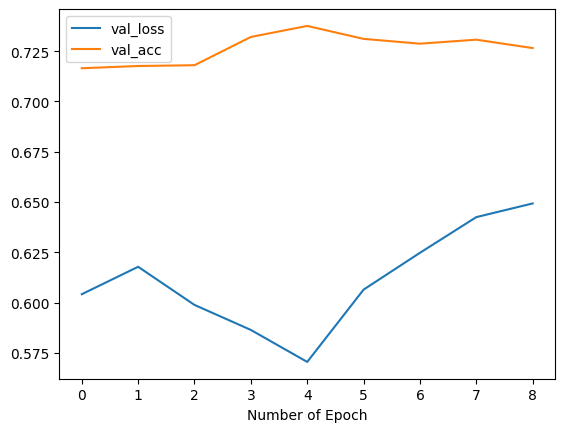

In [55]:
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['val_acc'],label='val_acc')
plt.xlabel('Number of Epoch')
plt.legend()

In [36]:
loaded_model = load_model('best_model.h5')

In [37]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [38]:
# 불용어(영화, 게임, 쇼핑과 직접적 연관 단어,조사,접속사 불필요한 단어 추가)
 
f = open("불용어사전.txt", 'r')
while True:
    line = f.readline()
    if not line: break
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()
print(stopwords)

['가', '걍', '게', '게임', '겜', '고', '과', '네', '는', '다', '도', '되', '들', '듯', '를', '만', '면', '명작', '영화', '에', '와', '으로', '은', '을', '음', '의', '이', '인', '임', '자', '잘', '좀', '지', '하', '하다', '한', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '곳', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면'

In [39]:
def sentiment_predict(new_sentence):

  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
  return score